In [3]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn import metrics
import shap
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
gameweek_df = pd.read_csv('data/processed/combined_gameweeks.csv',parse_dates=['date'])

In [5]:
gameweek_df.groupby('season')['name'].first()

season
2018-19    Aaron_Cresswell_402
2019-20    Aaron_Cresswell_376
2020-21         Aaron Connolly
2021-22            Eric Bailly
Name: name, dtype: object

In [219]:
swaps = [['Cristiano_Aveiro','Cristiano_Ronaldo'],
        ['Tino_Livramento','Valentino_Livramento'],
        ['Heung-Min_Son','Son_Heung-Min'],
        ['Emile_Rowe','Emile_Smith-Rowe'],
        ['Raphael_Belloli','Raphinha'],
        ['Benjamin_Chilwell','Ben_Chilwell',],
        ['Virgil_Dijk','Virgil_van_Dijk',],
        ['Richarlison_Andrade','Richarlison'],
        ['David_Martin','David_Raya'],
        ['Ederson_Moraes','Ederson'],
         ['Alisson_Becker','Alisson'],
         ['Allan_Loureiro','Allan'],
         ['David_Gea','David_de_Gea'],
        ]

In [220]:
def clean_name(name_series, swaps):
    split = name_series.str.replace("\_\d+","",regex=True).str.replace("_"," ", regex=False).str.replace('ï|í','i',regex=True).str.replace('á','a',regex=False).str.split()
    combined = split.str[0] + '_' +  split.str[-1]
    for from_, to in swaps:
        combined = combined.replace(from_, to)
    return combined


In [221]:
gameweek_df['clean_name'] = clean_name(gameweek_df.name, swaps)

In [222]:
understat_df = pd.read_csv('data/processed/understat_raw.csv',parse_dates=['date'])

In [223]:
understat_df['clean_name'] = understat_df.player.str.replace('\_\d+\.csv','',regex=True).str.replace('á','a',regex=False)

In [224]:
understat_df['xC'] = understat_df.xG + understat_df.xA

In [225]:
gameweek_df['has_understat'] = gameweek_df['clean_name'].isin(understat_df.clean_name)

In [226]:
gameweek_df.groupby('season')['has_understat'].mean()

season
2018-19    0.463699
2019-20    0.569522
2020-21    0.695916
2021-22    0.729935
Name: has_understat, dtype: float64

In [227]:
gameweek_df['weighted_us'] = gameweek_df.minutes * gameweek_df.has_understat

In [228]:
gameweek_df.groupby('season')['weighted_us'].sum() /  gameweek_df.groupby('season')['minutes'].sum()

season
2018-19    0.618992
2019-20    0.737958
2020-21    0.886499
2021-22    0.892131
dtype: float64

I'm sure I can go further but this is a good start :)

In [239]:
UNDERSTAT_COLS = ['xG',
 'xA', 
 'npg', 'npxG', 'xGChain', 'xGBuildup','xC'
]

In [240]:
with_understat = gameweek_df.merge(understat_df[ UNDERSTAT_COLS + ['clean_name','date']],
                  how='left',
                  on=['clean_name','date'],suffixes=('','_u'))
with_xg_data = with_understat.loc[with_understat.xG.notna()]
num = with_xg_data.loc[with_xg_data.xG.notna()].groupby('season')['clean_name'].count() 

denom = gameweek_df.loc[gameweek_df.minutes > 0].groupby('season')['clean_name'].count()
num /denom

season
2018-19    0.599046
2019-20    0.720471
2020-21    0.882710
2021-22    0.884662
Name: clean_name, dtype: float64

I'll work with this for now :) 

In [241]:
## can we help the model by showing the relationship between gk/defence and conceded?

In [242]:
with_understat[UNDERSTAT_COLS] = with_understat[UNDERSTAT_COLS].fillna(0)

In [243]:
combined_df = gameweek_df

In [244]:
combined_df.position = combined_df.groupby('clean_name')['position'].bfill()

In [245]:
combined_df['defensive_cleansheet'] = combined_df.clean_sheets & combined_df.position.isin(['DEF','MID'])

In [246]:
combined_df['defensive_goals_conceded'] = combined_df['goals_conceded'] 

In [247]:
combined_df.loc[~combined_df.position.isin(['DEF','MID']),['defensive_cleansheet',
                                                          'defensive_goals_conceded']] = np.nan

In [248]:
def add_moving_average(df, ma_columns, name_col,pref='ma4_', half_life=4):
    df = df.sort_values(by=[name_col, "season", "gw"]).reset_index(drop=True)
    ma_columns_output = [pref + c for c in ma_columns]
    df[ma_columns_output] = df.groupby(name_col)[ma_columns].apply(
        lambda x: x.ewm(halflife=half_life).mean()
    ).reset_index(drop=True)
    df[ma_columns_output] = df.groupby(name_col)[ma_columns_output].shift(1)
    return df

In [249]:
MA_COLS = [
    'assists', 'attempted_passes', 'big_chances_created',
       'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
       'clearances_blocks_interceptions', 'completed_passes', 'creativity',
       'dribbles', 'ea_index', 'errors_leading_to_goal',
       'errors_leading_to_goal_attempt', 'fouls', 'goals_conceded',
       'goals_scored', 'influence', 'key_passes',
        'loaned_in', 'loaned_out',
       'minutes', 'offside', 'open_play_crosses', 'opponent_team', 'own_goals',
       'penalties_conceded', 'penalties_missed', 'penalties_saved',
       'recoveries', 'red_cards', 'saves', 'selected', 'tackled',
       'tackles', 'target_missed', 'team_a_score', 'team_h_score', 'threat',
        'winning_goals', 'yellow_cards','total_points',
    'ict_index','xP','defensive_cleansheet','defensive_goals_conceded'
            ] #+ UNDERSTAT_COLS 

In [271]:
EXCLUDE_COLS = ['name','clean_name','element','id',
               'id', 'kickoff_time',
       'kickoff_time_formatted', 'round','fixture', 'date','weighted_us', 'has_understat', 'weight'] + MA_COLS 

In [272]:
combined_df['prev_selected'] = combined_df.groupby('clean_name')['selected'].shift(1)

In [273]:
combined_df.total_points =pd.to_numeric(combined_df.total_points)

In [274]:
cat_cols = combined_df.select_dtypes('O').columns
combined_df[cat_cols] = combined_df[cat_cols].astype('category')

In [296]:
HL = 20
with_ma = add_moving_average(combined_df, MA_COLS,'clean_name',pref=f'ma_{HL}_', half_life=HL)

In [297]:
with_ma['weight']= (pd.Timestamp.now() - with_ma.date).dt.days * with_ma.selected # higher weight on more recent data, and more highly selected players

In [321]:
train = with_ma[(with_ma.season != '2020-21') | (with_ma.gw <= 19)]
val = with_ma[(with_ma.season == '2020-21') & (with_ma.gw > 19)]
test = with_ma[with_ma.season == '2021-22']

In [322]:
X_train, X_test, X_val = train.drop(columns = EXCLUDE_COLS), test.drop(columns=EXCLUDE_COLS), val.drop(columns=EXCLUDE_COLS)
y_train, y_test, y_val = train.total_points, test.total_points, val.total_points
w_train, w_test, w_val = train.weight, test.weight, val.weight

In [353]:
def fit_with_early_stopping(X_train, y_train, X_val, y_val, w_train, w_val):
    reg = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=10_000)
    reg.fit(X_train,y_train,sample_weight=w_train,
                              eval_set=[(X_train, y_train), (X_val, y_val)], 
            early_stopping_rounds=10,verbose=100)
    num_trees = res._Booster.num_trees()
    reg_2 = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=num_trees)
    reg_2.fit(X_train.append(X_val), y_train.append(y_val), sample_weight=w_train.append(w_val))
    return reg_2, num_trees

In [346]:
reg, num_trees = fit_with_early_stopping(X_train, y_train, X_val, y_val, w_train, w_val)

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 10 rounds
[100]	training's l2: 10.3617	valid_1's l2: 5.34668
[200]	training's l2: 9.03143	valid_1's l2: 4.47675
[300]	training's l2: 8.23362	valid_1's l2: 4.32595
Early stopping, best iteration is:
[372]	training's l2: 7.78432	valid_1's l2: 4.28275


In [347]:
y_pred = reg.predict(X_test)

In [348]:
y_dummy = np.repeat(y_train.mean(), len(X_test))

In [349]:
metrics.mean_squared_error(y_pred,y_test,sample_weight=w_test)

11.216906804798388

In [350]:
metrics.mean_squared_error(y_dummy,y_test,sample_weight=w_test)

19.6538930990834

In [351]:
def create_shaps(X,y,reg):
    explainer = shap.TreeExplainer(reg)
    shap_values = explainer.shap_values(X)
    # rank features by importance - average abs. shap value
    importance_shap = np.abs(shap_values).mean(axis=0)
    ranked_features = sorted(
        list(zip(X.columns, importance_shap)), key=lambda x: -x[1]
    )  # sorted by importance (descending)
    features_df = pd.DataFrame(ranked_features, columns=["feature", "importance"])
    features_df["% total importance"] = (
        features_df.importance / features_df.importance.sum()
    ) * 100
    ax = sns.barplot(data=features_df.head(20), y="feature", x="% total importance")
    plt.title("Top 20 features \n % Average abs. Shap value importance (% total)")
    plt.show()
    ax = shap.summary_plot(
        shap_values,
        X,
    )
    plt.show()
    X_plot = X.copy()
    for col in X.select_dtypes("category").columns:
        X_plot[col] = X[col].cat.codes
    for feat in ranked_features[:10]:
        ax = shap.dependence_plot(
        ind=feat[0],
        shap_values=shap_values,
        features=X_plot,
        display_features=X,
        )
        plt.show()

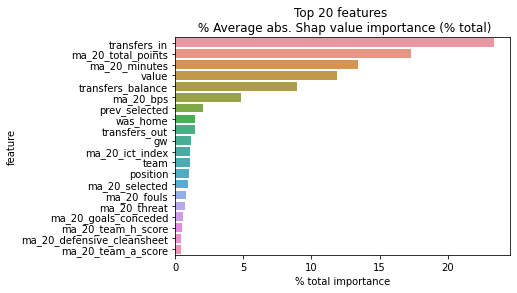

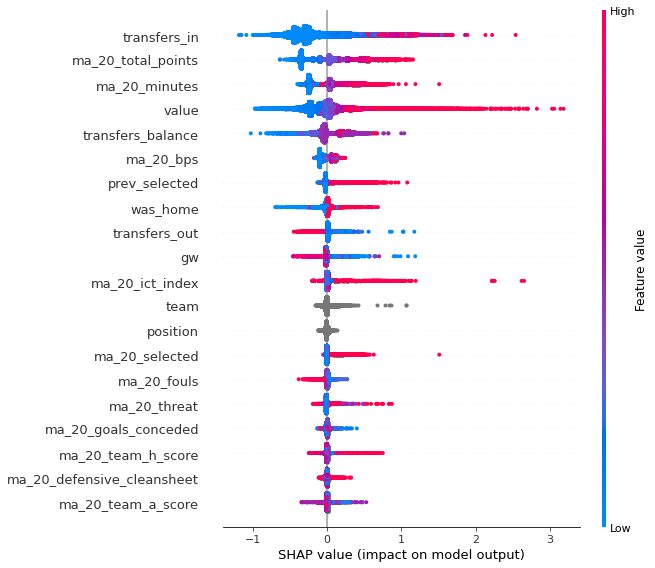

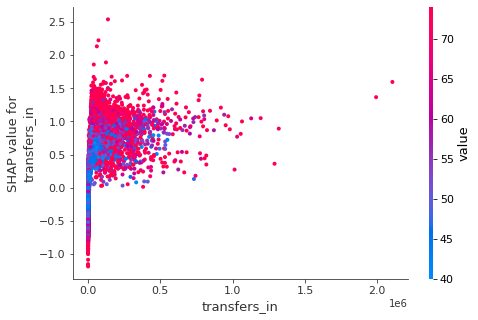

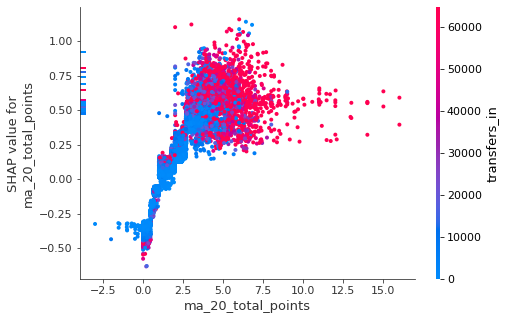

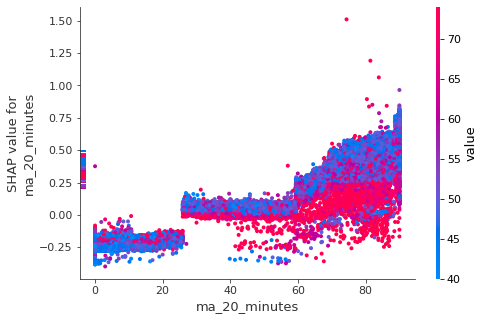

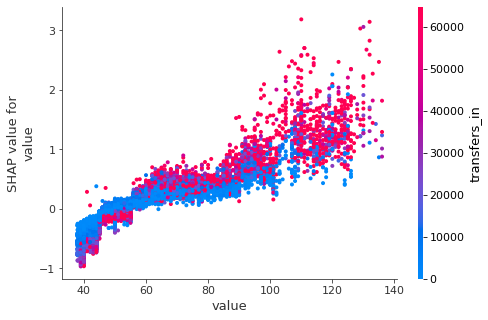

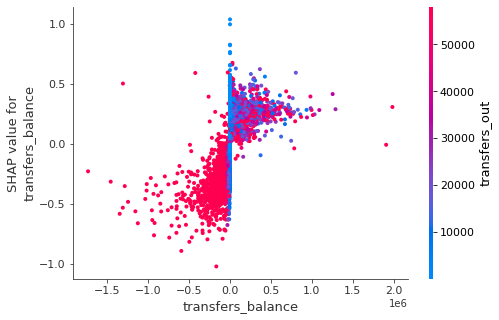

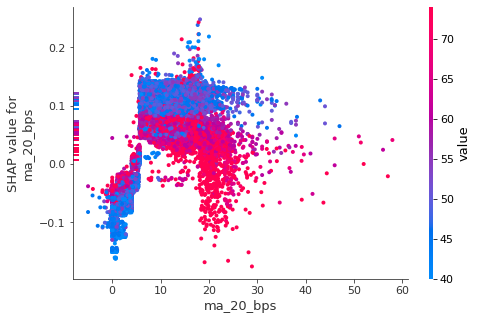

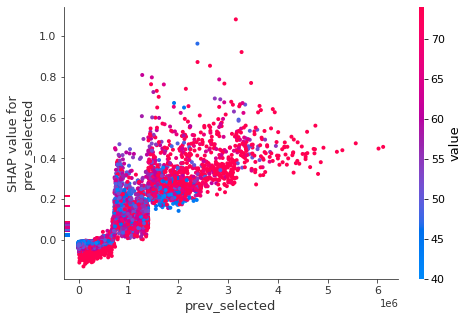

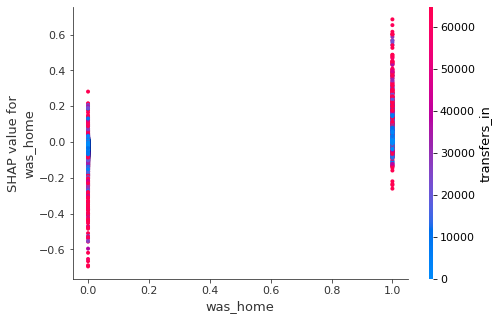

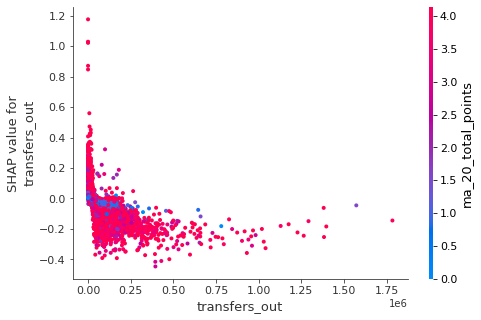

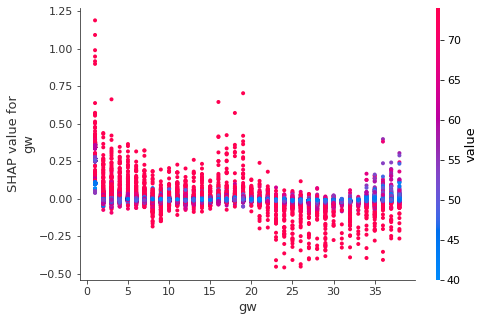

In [352]:
create_shaps(X_train,y_train,reg)

In [356]:
X = with_ma.drop(columns=EXCLUDE_COLS)

In [357]:
y = with_ma.total_points

In [359]:
w = with_ma.weight

In [366]:
reg_2 = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=num_trees)

In [367]:
reg_2.fit(X,y,w)

LGBMRegressor(learning_rate=0.01, n_estimators=372)

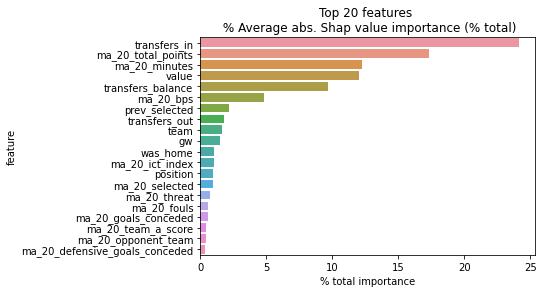

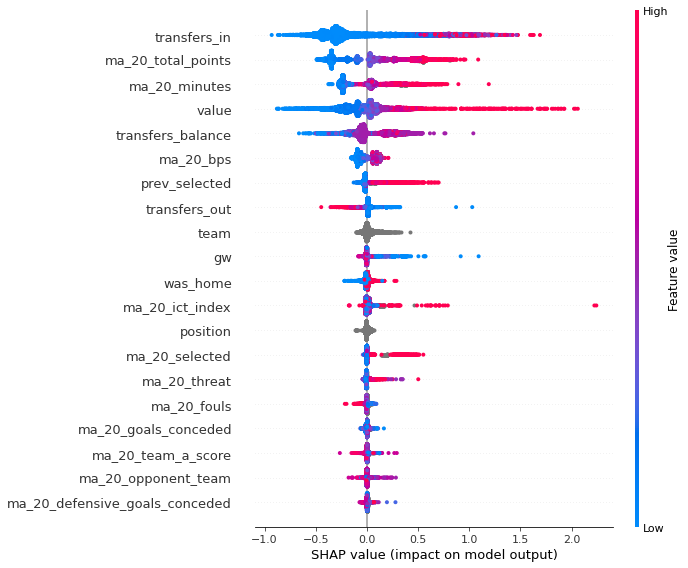

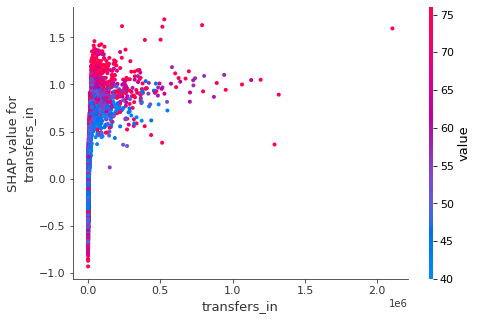

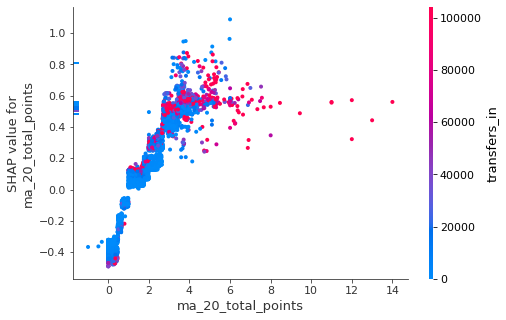

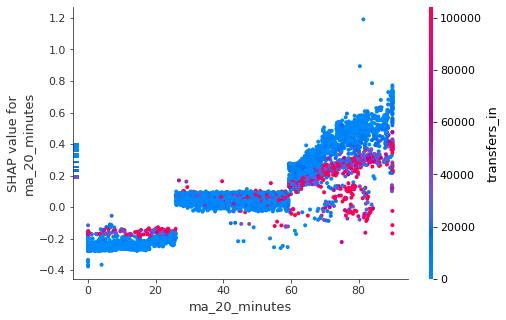

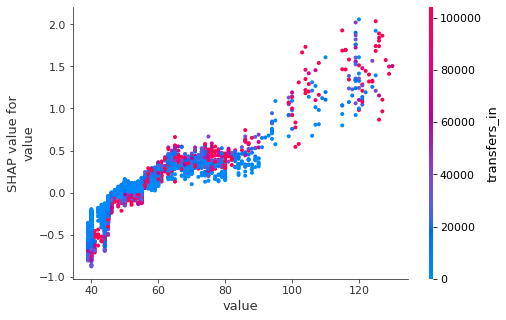

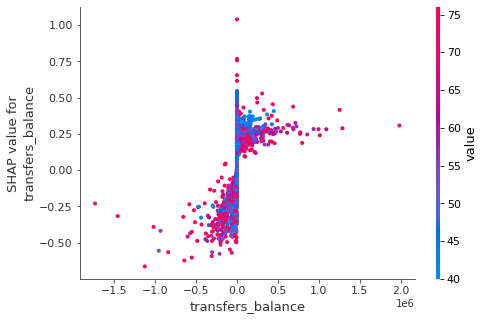

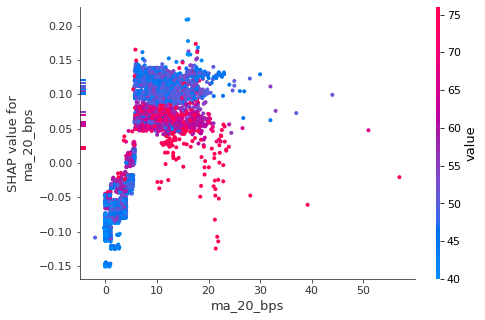

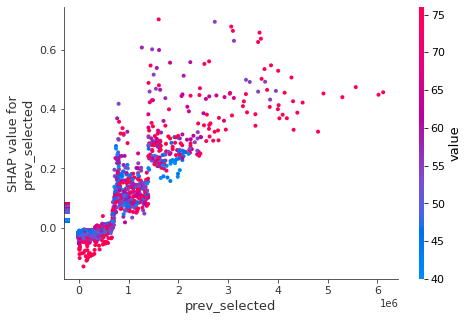

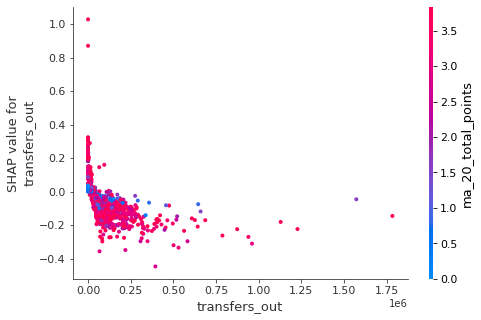

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


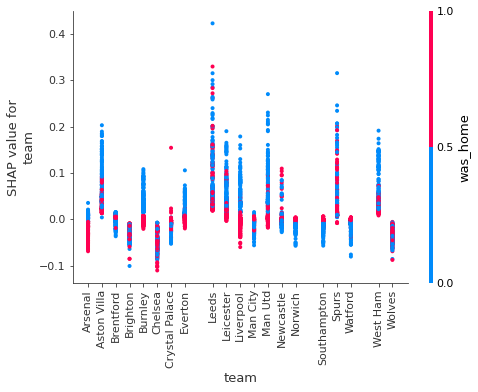

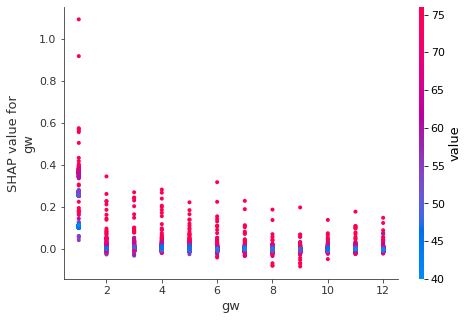

In [368]:
create_shaps(X_test,y_test,reg_2)

In [409]:
#a little leaky. What would the model predict for last week? 
_X_test = X_test.copy()
_X_test['pred'] = reg_2.predict(X_test)
_X_test['name'] = test.clean_name
_X_test['position'] =test.position

In [413]:
latest = _X_test.drop_duplicates(subset=['name'],keep='last').copy()
latest['rank'] = latest.pred.rank(ascending=False)

In [414]:
top_40 = latest[['name','rank','pred','position','value',]].sort_values(by='pred',ascending=False).head(40)

In [421]:
import plotly.express as px

fig = px.scatter(top_40, x="pred", y="value", text="name", log_x=True, color="position")
fig.update_traces(textposition='top center')
fig.update_layout(title_text='Points vs. Price', title_x=0.5)
fig.write_html('forecast points vs. price.html', auto_open=True)


In [415]:
top_40

,name,rank,pred,position,value
62692,Son_Heung-Min,1.0,6.855878,MID,104
49075,Mohamed_Salah,2.0,6.270087,MID,130
55059,Pierre-Emerick_Aubameyang,3.0,5.896304,FWD,100
30738,Jamie_Vardy,4.0,5.824094,FWD,107
59724,Sadio_Mané,5.0,5.762824,MID,119
25699,Harry_Kane,6.0,5.705566,FWD,122
14312,Cristiano_Ronaldo,7.0,5.404214,FWD,124
10275,Bruno_Fernandes,8.0,5.183573,MID,117
56070,Reece_James,9.0,4.789740,DEF,60
66025,Trent_Alexander-Arnold,10.0,4.738268,DEF,77


In [416]:
sns.scatterplot(data=top_40, x='pred', y=

,transfers_balance,transfers_in,transfers_out,value,was_home,gw,season,position,team,prev_selected,...,ma_20_winning_goals,ma_20_yellow_cards,ma_20_total_points,ma_20_ict_index,ma_20_xP,ma_20_defensive_cleansheet,ma_20_defensive_goals_conceded,pred,name,rank
27894,-136963,54415,191378,67,False,12,2021-22,FWD,Brentford,1975809.0,...,NaN,0.188905,3.362273,6.391432,3.001894,NaN,NaN,3.478458,Ivan_Toney,56.0
